In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split

# Configurações gerais
EPOCHS = 200
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Caminho para o dataset "Doencas-Olhos"
DATA_DIR = 'datasetsTCC/Doencas-Olhos'

# 1. Definir as transformações da imagem
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ==============================================================================
# --- MUDANÇA: CLASSE DE DATASET ATUALIZADA PARA LER OS LABELS ---
# Esta versão assume que sua estrutura de pastas é: DATA_DIR/nome_da_classe/imagem.jpg
# ==============================================================================
class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Encontra as pastas de classes e cria um mapeamento (ex: {'normal': 0, 'catarata': 1, ...})
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        print(f"Classes encontradas: {self.class_to_idx}")

        # Percorre cada pasta de classe para carregar imagens e labels
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            for ext in ('*.jpg', '*.jpeg', '*.png'):
                files_in_class = glob.glob(os.path.join(class_dir, ext))
                self.image_files.extend(files_in_class)
                self.labels.extend([class_idx] * len(files_in_class))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label # Agora retorna a imagem e o label real

# ==============================================================================
# --- MUDANÇA: DIVISÃO ESTRATIFICADA E CRIAÇÃO DOS DATALOADERS ---
# ==============================================================================

# Carrega o dataset completo (agora com labels)
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform)

# Apenas continue se imagens foram encontradas
if len(full_dataset) > 0:
    # 1. Obter os labels para a estratificação
    dataset_labels = full_dataset.labels
    dataset_indices = list(range(len(full_dataset)))

    # 2. Primeira divisão: 70% treino, 30% para o restante (estratificada)
    train_indices, temp_indices, _, temp_labels = train_test_split(
        dataset_indices, dataset_labels, test_size=0.30, stratify=dataset_labels, random_state=42
    )

    # 3. Segunda divisão: divide os 30% em metades (15% validação, 15% teste)
    val_indices, test_indices, _, _ = train_test_split(
        temp_indices, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
    )

    # 4. Criar os objetos de Dataset do PyTorch usando os índices
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    print(f"\nDivisão estratificada concluída:")
    print(f"Conjunto de Treino: {len(train_dataset)} imagens")
    print(f"Conjunto de Validação: {len(val_dataset)} imagens")
    print(f"Conjunto de Teste: {len(test_dataset)} imagens")

    # 5. Criar os DataLoaders para cada conjunto
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\nDataLoaders de treino, validação e teste criados com sucesso!")

else:
    print("ERRO: O dataset está vazio ou as classes não foram encontradas no formato esperado.")
    # Cria loaders vazios para evitar erros no resto do script
    train_loader = DataLoader([], batch_size=BATCH_SIZE)
    val_loader = DataLoader([], batch_size=BATCH_SIZE)
    test_loader = DataLoader([], batch_size=BATCH_SIZE)


# Função para visualizar as imagens (seu código original)
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    # Ensure we don't plot more than available images
    num_images_to_plot = min(n, original.size(0))
    for i in range(num_images_to_plot):
        # Imagem original
        ax = plt.subplot(2, num_images_to_plot, i + 1)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        img = original[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Originais")

        # Imagem reconstruída
        ax = plt.subplot(2, num_images_to_plot, i + 1 + num_images_to_plot)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        rec_img = reconstructed[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(rec_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Reconstruídas")
    plt.show()

# A partir daqui, você pode adicionar o código de treinamento de qualquer autoencoder,
# lembrando de usar os DataLoaders corretos (train_loader, val_loader, test_loader).

Usando dispositivo: cuda
Classes encontradas: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

Divisão estratificada concluída:
Conjunto de Treino: 2951 imagens
Conjunto de Validação: 633 imagens
Conjunto de Teste: 633 imagens

DataLoaders de treino, validação e teste criados com sucesso!


Teste

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Lembre-se de corrigir a importação das métricas para a versão moderna
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, NormalizedRootMeanSquaredError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# Supondo que suas configurações (EPOCHS, LEARNING_RATE, etc.) e os DataLoaders já estejam definidos.

# --- 1. DEFINIÇÃO DO MODELO MAIS PROFUNDO (5 CAMADAS) ---
class DeeperConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(DeeperConvolutionalAutoencoder, self).__init__()

        # Encoder com 5 camadas para comprimir de 512x512 para 16x16
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 512, 512]
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),       # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),      # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),      # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),     # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),    # -> [N, 256, 16, 16] (Gargalo)
            nn.ReLU(),
        )

        # Decoder com 5 camadas para reconstruir de 16x16 para 512x512
        self.decoder = nn.Sequential(
            # Entrada: [N, 256, 16, 16]
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 128, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [N, 64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 32, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 16, 256, 256]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> [N, 1, 512, 512]
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- 2. TREINAMENTO DO MODELO PROFUNDO COM MÉTRICAS ---
model_deep_vanilla = DeeperConvolutionalAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_deep_vanilla.parameters(), lr=LEARNING_RATE)

# Instanciar os objetos das três métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss = 0
    model_deep_vanilla.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        outputs = model_deep_vanilla(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss/len(train_loader)

    print(f"Deep Vanilla AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados no conjunto de teste ---")
model_deep_vanilla.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_deep_vanilla(test_images)

    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)

    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 4. CONGELAR E SALVAR O ENCODER PROFUNDO TREINADO ---
print("\n--- Congelando e salvando o encoder ---")

trained_encoder = model_deep_vanilla.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_deep_encoder.pth')
print("Encoder profundo congelado e salvo com sucesso em 'frozen_deep_encoder.pth'!")

Vanilla AE | Epoch [1/160], Loss: 0.4311, PSNR: 10.97 dB, SSIM: -0.0033, NRMSE: -1.4871
Vanilla AE | Epoch [2/160], Loss: 0.1325, PSNR: 19.52 dB, SSIM: 0.4138, NRMSE: -0.5559
Vanilla AE | Epoch [3/160], Loss: 0.0746, PSNR: 22.64 dB, SSIM: 0.6626, NRMSE: -0.3882
Vanilla AE | Epoch [4/160], Loss: 0.0557, PSNR: 24.52 dB, SSIM: 0.7355, NRMSE: -0.3124
Vanilla AE | Epoch [5/160], Loss: 0.0463, PSNR: 25.70 dB, SSIM: 0.7837, NRMSE: -0.2729
Vanilla AE | Epoch [6/160], Loss: 0.0404, PSNR: 26.60 dB, SSIM: 0.8151, NRMSE: -0.2460
Vanilla AE | Epoch [7/160], Loss: 0.0361, PSNR: 27.48 dB, SSIM: 0.8389, NRMSE: -0.2222
Vanilla AE | Epoch [8/160], Loss: 0.0331, PSNR: 28.27 dB, SSIM: 0.8555, NRMSE: -0.2029
Vanilla AE | Epoch [9/160], Loss: 0.0302, PSNR: 29.00 dB, SSIM: 0.8684, NRMSE: -0.1865
Vanilla AE | Epoch [10/160], Loss: 0.0284, PSNR: 29.57 dB, SSIM: 0.8779, NRMSE: -0.1747
Vanilla AE | Epoch [11/160], Loss: 0.0269, PSNR: 30.09 dB, SSIM: 0.8856, NRMSE: -0.1645
Vanilla AE | Epoch [12/160], Loss: 0.026

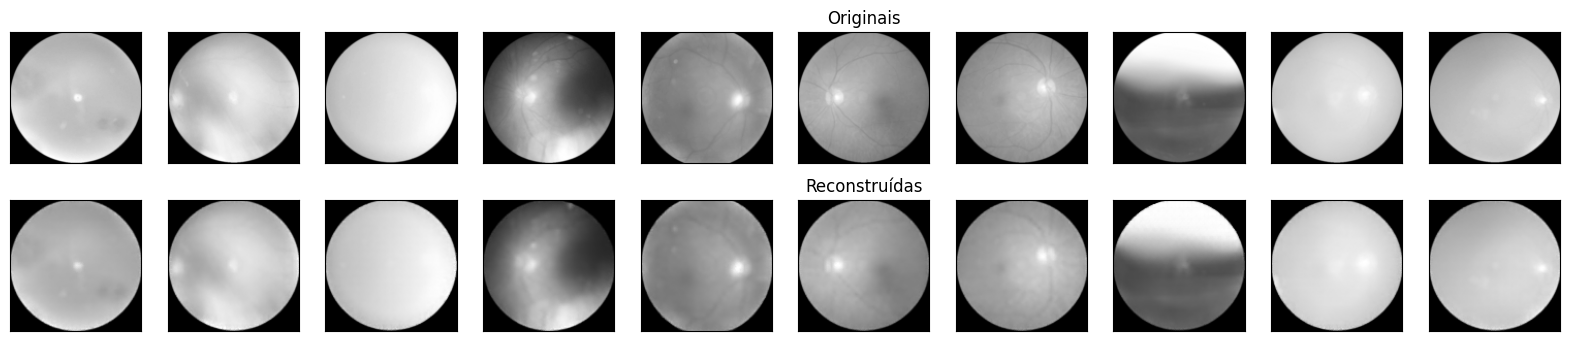


--- Congelando e salvando o encoder ---
Encoder congelado e salvo com sucesso em 'frozen_encoder.pth'!


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
# MUDANÇA: Adicionar a métrica NRMSE
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, NormalizedRootMeanSquaredError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# --- 1. Definição do Modelo (sem alterações) ---
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- 2. Treinamento do Modelo com Métricas ---
model_vanilla = ConvolutionalAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=LEARNING_RATE)

# MUDANÇA: Instanciar os objetos das três métricas
# O data_range é 2.0 porque suas imagens estão normalizadas em [-1, 1]
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE) # MUDANÇA: Adicionar NRMSE

for epoch in range(EPOCHS):
    total_loss = 0
    model_vanilla.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        outputs = model_vanilla(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # MUDANÇA: Atualizar todas as métricas a cada lote
        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images) # MUDANÇA: Adicionar NRMSE

    # MUDANÇA: Calcular as métricas para a época inteira e resetar
    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute() # MUDANÇA: Adicionar NRMSE

    psnr_metric.reset()
    ssim_metric.reset()
    nrmse_metric.reset() # MUDANÇA: Adicionar NRMSE

    avg_loss = total_loss/len(train_loader)

    # MUDANÇA: Print mais informativo com todas as métricas
    print(f"Vanilla AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. Visualização e Métricas Finais no Teste ---
print("\n--- Visualizando e Avaliando resultados no conjunto de teste ---")
model_vanilla.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_vanilla(test_images)

    # MUDANÇA: Calcular e imprimir as três métricas finais para o lote de teste
    final_psnr = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
    final_ssim = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
    final_nrmse = NormalizedRootMeanSquaredError().to(DEVICE) # MUDANÇA: Adicionar NRMSE

    psnr_val = final_psnr(reconstructed_images, test_images)
    ssim_val = final_ssim(reconstructed_images, test_images)
    nrmse_val = final_nrmse(reconstructed_images, test_images) # MUDANÇA: Adicionar NRMSE

    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 4. Congelar e Salvar o Encoder Treinado (sem alterações) ---
print("\n--- Congelando e salvando o encoder ---")

trained_encoder = model_vanilla.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_encoder.pth')
print("Encoder congelado e salvo com sucesso em 'frozen_encoder.pth'!")

Autoencoder Esparso

Sparse AE | Epoch [1/160], Loss: 0.4337, Recon: 0.3963, Sparsity: 37.4475, PSNR: 11.75 dB, SSIM: 0.0241, NRMSE: -1.3594
Sparse AE | Epoch [2/160], Loss: 0.1835, Recon: 0.1391, Sparsity: 44.3256, PSNR: 19.37 dB, SSIM: 0.3398, NRMSE: -0.5653
Sparse AE | Epoch [3/160], Loss: 0.1107, Recon: 0.0696, Sparsity: 41.1875, PSNR: 23.14 dB, SSIM: 0.6841, NRMSE: -0.3663
Sparse AE | Epoch [4/160], Loss: 0.0921, Recon: 0.0525, Sparsity: 39.6771, PSNR: 24.76 dB, SSIM: 0.7640, NRMSE: -0.3040
Sparse AE | Epoch [5/160], Loss: 0.0834, Recon: 0.0448, Sparsity: 38.5919, PSNR: 25.91 dB, SSIM: 0.7987, NRMSE: -0.2662
Sparse AE | Epoch [6/160], Loss: 0.0774, Recon: 0.0395, Sparsity: 37.9014, PSNR: 26.83 dB, SSIM: 0.8230, NRMSE: -0.2395
Sparse AE | Epoch [7/160], Loss: 0.0730, Recon: 0.0356, Sparsity: 37.4103, PSNR: 27.66 dB, SSIM: 0.8425, NRMSE: -0.2176
Sparse AE | Epoch [8/160], Loss: 0.0695, Recon: 0.0325, Sparsity: 36.9973, PSNR: 28.39 dB, SSIM: 0.8581, NRMSE: -0.2001
Sparse AE | Epoch [9/160], Loss: 0.0666,

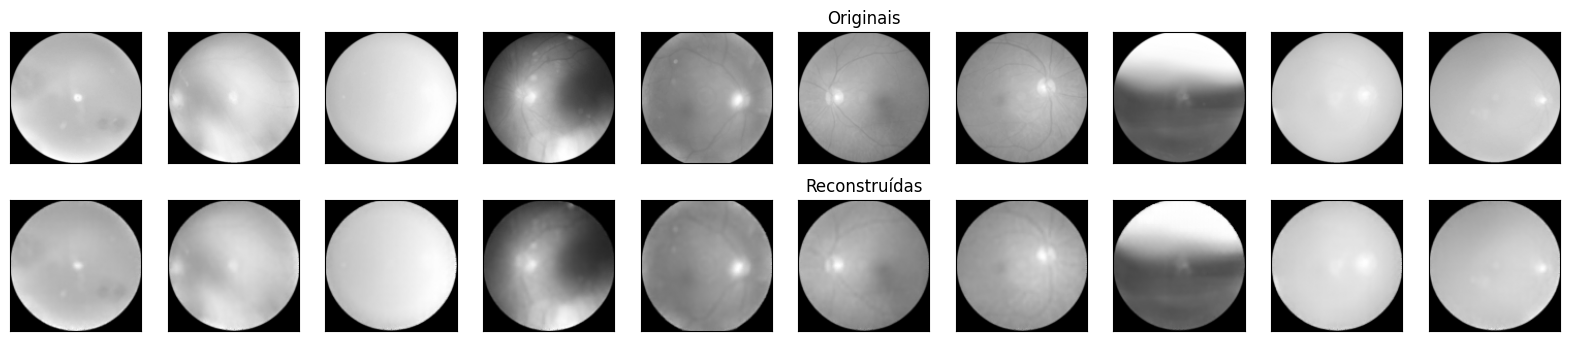


--- Congelando e salvando o encoder ---
Encoder Esparso congelado e salvo com sucesso em 'frozen_sparse_encoder.pth'!

--- Exemplo de como carregar o encoder esparso ---
Os parâmetros do encoder carregado estão congelados? False


In [9]:
# --- 1. FUNÇÃO AUXILIAR PARA A PENALIDADE DE ESPARSIDADE ---
def kl_divergence_sparsity(rho, rho_hat):
    activations = torch.sigmoid(rho_hat)
    avg_activations = activations.mean(dim=(0, 2, 3))
    avg_activations = torch.clamp(avg_activations, 1e-6, 1 - 1e-6)
    kl_div = rho * torch.log(rho / avg_activations) + (1 - rho) * torch.log((1 - rho) / (1 - avg_activations))
    return torch.sum(kl_div)

# --- 2. DEFINIÇÃO DO MODELO ---
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)
    def forward(self, x): return self.decode(self.encode(x))

# --- 3. TREINAMENTO DO MODELO ESPARSO COM MÉTRICAS ---
SPARSITY_TARGET = 0.05
SPARSITY_WEIGHT = 1e-3

model_sparse = SparseAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_sparse.parameters(), lr=LEARNING_RATE)

# NOVO: Instanciar os objetos das métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss, total_recon_loss, total_sparsity_loss = 0, 0, 0
    model_sparse.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        encoded_activations = model_sparse.encode(images)
        outputs = model_sparse.decode(encoded_activations)

        recon_loss = criterion(outputs, images)
        sparsity_loss = kl_divergence_sparsity(SPARSITY_TARGET, encoded_activations)
        loss = recon_loss + SPARSITY_WEIGHT * sparsity_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_sparsity_loss += sparsity_loss.item()

        # NOVO: Atualizar as métricas a cada lote
        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    # NOVO: Calcular as métricas para a época e resetar
    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon_loss / len(train_loader)
    avg_sparsity = total_sparsity_loss / len(train_loader)

    # MUDANÇA: Print mais detalhado com todas as perdas e métricas
    print(f"Sparse AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, Sparsity: {avg_sparsity:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 4. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados do Sparse Autoencoder ---")
model_sparse.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_sparse(test_images)

    # NOVO: Calcular e imprimir as métricas finais para o lote de teste
    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 5. (NOVO) CONGELAR E SALVAR O ENCODER TREINADO ---
print("\n--- Congelando e salvando o encoder ---")

trained_encoder = model_sparse.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_sparse_encoder.pth')
print("Encoder Esparso congelado e salvo com sucesso em 'frozen_sparse_encoder.pth'!")

# --- 6. (BÔNUS) Exemplo de Como Carregar e Usar o Encoder Depois ---
print("\n--- Exemplo de como carregar o encoder esparso ---")

# Para usar o encoder, você precisa definir a mesma arquitetura
encoder_architecture = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU()
)

# Crie uma nova instância e carregue os pesos salvos
loaded_encoder = encoder_architecture
loaded_encoder.load_state_dict(torch.load('frozen_sparse_encoder.pth'))
loaded_encoder.to(DEVICE)
loaded_encoder.eval()

is_frozen = all(not param.requires_grad for param in loaded_encoder.parameters())
print(f"Os parâmetros do encoder carregado estão congelados? {is_frozen}")

Denoising AutoEncoder

Denoising AE | Epoch [1/160], Loss: 0.3698, PSNR: 12.11 dB, SSIM: 0.0169, NRMSE: -1.3035
Denoising AE | Epoch [2/160], Loss: 0.1152, PSNR: 21.07 dB, SSIM: 0.4805, NRMSE: -0.4647
Denoising AE | Epoch [3/160], Loss: 0.0684, PSNR: 24.10 dB, SSIM: 0.6949, NRMSE: -0.3278
Denoising AE | Epoch [4/160], Loss: 0.0533, PSNR: 25.44 dB, SSIM: 0.7681, NRMSE: -0.2811
Denoising AE | Epoch [5/160], Loss: 0.0453, PSNR: 26.51 dB, SSIM: 0.8058, NRMSE: -0.2486
Denoising AE | Epoch [6/160], Loss: 0.0403, PSNR: 27.54 dB, SSIM: 0.8319, NRMSE: -0.2207
Denoising AE | Epoch [7/160], Loss: 0.0352, PSNR: 28.49 dB, SSIM: 0.8517, NRMSE: -0.1978
Denoising AE | Epoch [8/160], Loss: 0.0321, PSNR: 29.19 dB, SSIM: 0.8652, NRMSE: -0.1826
Denoising AE | Epoch [9/160], Loss: 0.0305, PSNR: 29.73 dB, SSIM: 0.8747, NRMSE: -0.1716
Denoising AE | Epoch [10/160], Loss: 0.0281, PSNR: 30.27 dB, SSIM: 0.8837, NRMSE: -0.1612
Denoising AE | Epoch [11/160], Loss: 0.0267, PSNR: 30.73 dB, SSIM: 0.8904, NRMSE: -0.1529
Denoising AE | Epoc

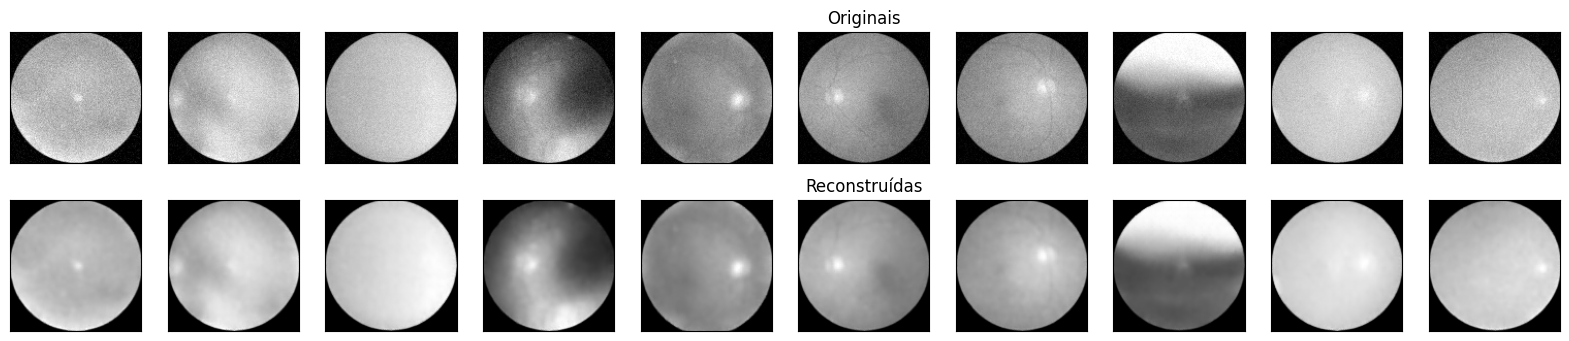


--- Congelando e salvando o encoder ---
Encoder Denoising congelado e salvo com sucesso em 'frozen_denoising_encoder.pth'!

--- Exemplo de como carregar o encoder denoising ---
Os parâmetros do encoder carregado estão congelados? False


In [10]:
# --- 1. DEFINIÇÃO DO MODELO DENOISING AUTOENCODER ---
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # CORREÇÃO: A linha .view() era redundante, pois a saída do decoder já tem o formato correto.
        # A remoção torna o código mais limpo e robusto.
        return decoded

# --- 2. TREINAMENTO DO MODELO COM MÉTRICAS ---
model_denoising = DenoisingAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_denoising.parameters(), lr=LEARNING_RATE)
noise_factor = 0.07

# NOVO: Instanciar os objetos das métricas
psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    total_loss = 0
    model_denoising.train()

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        # Adicionar ruído às imagens de entrada
        noisy_images = images + noise_factor * torch.randn(*images.shape, device=DEVICE)
        noisy_images = torch.clamp(noisy_images, -1., 1.)

        # A entrada é ruidosa, mas o alvo é a imagem limpa
        outputs = model_denoising(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # NOVO: Atualizar as métricas (comparando a saída limpa com o alvo limpo)
        psnr_metric.update(outputs, images)
        ssim_metric.update(outputs, images)
        nrmse_metric.update(outputs, images)

    # NOVO: Calcular as métricas para a época e resetar
    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    avg_loss = total_loss / len(train_loader)

    # MUDANÇA: Print mais informativo com todas as métricas
    print(f"Denoising AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE ---
print("\n--- Visualizando e Avaliando resultados do Denoising Autoencoder ---")
model_denoising.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    # Cria uma versão ruidosa para alimentar o modelo
    noisy_test_images = test_images + noise_factor * torch.randn(*test_images.shape, device=DEVICE)
    noisy_test_images = torch.clamp(noisy_test_images, -1., 1.)

    reconstructed_images = model_denoising(noisy_test_images)

    # NOVO: Calcular e imprimir as métricas finais (comparando a saída limpa com o alvo limpo)
    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    # Plotamos a imagem ruidosa (entrada) vs. a imagem reconstruída/limpa (saída)
    plot_images(noisy_test_images, reconstructed_images)

# --- 4. (NOVO) CONGELAR E SALVAR O ENCODER TREINADO ---
print("\n--- Congelando e salvando o encoder ---")

trained_encoder = model_denoising.encoder
for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_denoising_encoder.pth')
print("Encoder Denoising congelado e salvo com sucesso em 'frozen_denoising_encoder.pth'!")

# --- 5. (BÔNUS) Exemplo de Como Carregar e Usar o Encoder Depois ---
print("\n--- Exemplo de como carregar o encoder denoising ---")

# Para usar o encoder, você precisa definir a mesma arquitetura
encoder_architecture = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU()
)

# Crie uma nova instância e carregue os pesos salvos
loaded_encoder = encoder_architecture
loaded_encoder.load_state_dict(torch.load('frozen_denoising_encoder.pth'))
loaded_encoder.to(DEVICE)
loaded_encoder.eval()

is_frozen = all(not param.requires_grad for param in loaded_encoder.parameters())
print(f"Os parâmetros do encoder carregado estão congelados? {is_frozen}")

VAE Autoencoder

VAE | Epoch [1/160], Loss: 577730.8816, PSNR: 14.54 dB, SSIM: 0.2128, NRMSE: -0.9858
VAE | Epoch [2/160], Loss: 324952.0170, PSNR: 17.93 dB, SSIM: 0.4168, NRMSE: -0.6671
VAE | Epoch [3/160], Loss: 269481.8906, PSNR: 19.22 dB, SSIM: 0.4942, NRMSE: -0.5750
VAE | Epoch [4/160], Loss: 207458.1151, PSNR: 21.46 dB, SSIM: 0.5889, NRMSE: -0.4442
VAE | Epoch [5/160], Loss: 170480.1989, PSNR: 23.19 dB, SSIM: 0.6639, NRMSE: -0.3642
VAE | Epoch [6/160], Loss: 151055.8286, PSNR: 23.86 dB, SSIM: 0.7030, NRMSE: -0.3373
VAE | Epoch [7/160], Loss: 144188.8982, PSNR: 24.21 dB, SSIM: 0.7201, NRMSE: -0.3239
VAE | Epoch [8/160], Loss: 137158.8189, PSNR: 24.54 dB, SSIM: 0.7357, NRMSE: -0.3119
VAE | Epoch [9/160], Loss: 131510.7820, PSNR: 24.80 dB, SSIM: 0.7483, NRMSE: -0.3026
VAE | Epoch [10/160], Loss: 120111.4538, PSNR: 25.32 dB, SSIM: 0.7670, NRMSE: -0.2849
VAE | Epoch [11/160], Loss: 117278.6070, PSNR: 25.58 dB, SSIM: 0.7761, NRMSE: -0.2765
VAE | Epoch [12/160], Loss: 116524.5942, PSNR: 25.72 dB, SSIM: 

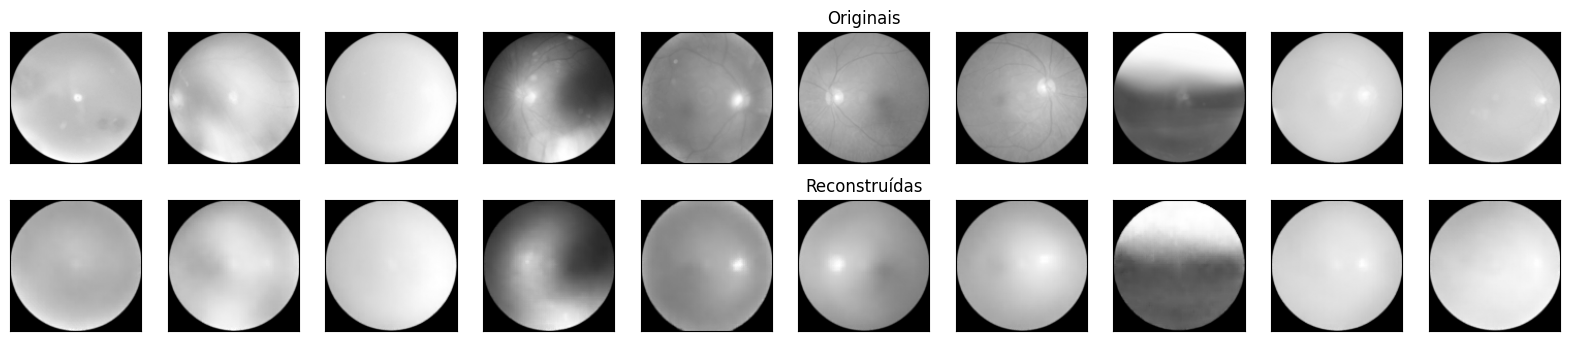


--- Congelando e salvando o encoder do VAE ---
Encoder VAE (até mu) congelado e salvo com sucesso em 'frozen_vae_encoder.pth'!


In [19]:
# --- 1. DEFINIÇÃO DO MODELO VAE (sem alterações) ---
class ConvolutionalVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvolutionalVAE, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.flattened_size = 64 * 16 * 16
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(self.flattened_size, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        recon_h = self.decoder_fc(z)
        recon_x = self.decoder_conv(recon_h)
        return recon_x, mu, log_var

def loss_function(recon_x, x, mu, log_var, beta=0.1):
    RECON_LOSS = F.l1_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return RECON_LOSS, KLD, RECON_LOSS + beta * KLD

# --- 2. TREINAMENTO DO MODELO COM MÉTRICAS (SEÇÃO MODIFICADA) ---
model_vae = ConvolutionalVAE().to(DEVICE)
optimizer = optim.Adam(model_vae.parameters(), lr=LEARNING_RATE)

psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

for epoch in range(EPOCHS):
    # CORREÇÃO: Apenas a perda total é necessária para o print final.
    total_loss = 0
    model_vae.train()

    # CORREÇÃO: Removida a barra de progresso tqdm para corresponder ao output do código base.
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        recon_images, mu, log_var = model_vae(images)
        # A função de perda retorna os componentes, mas só usamos o 'loss' total para o backpropagation.
        recon_loss, kld_loss, loss = loss_function(recon_images, images, mu, log_var, beta=0.1)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vae.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        psnr_metric.update(recon_images, images)
        ssim_metric.update(recon_images, images)
        nrmse_metric.update(recon_images, images)

    epoch_psnr = psnr_metric.compute()
    epoch_ssim = ssim_metric.compute()
    epoch_nrmse = nrmse_metric.compute()
    psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

    # CORREÇÃO: Média da perda calculada por lote (len(train_loader)) para igualar ao código base.
    avg_loss = total_loss / len(train_loader)

    # CORREÇÃO: Print formatado para ser idêntico ao do Denoising AE, removendo Recon e KLD.
    print(f"VAE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
          f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# --- 3. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE (sem alterações) ---
print("\n--- Visualizando e Avaliando resultados do VAE ---")
model_vae.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images, _, _ = model_vae(test_images)

    psnr_val = psnr_metric(reconstructed_images, test_images)
    ssim_val = ssim_metric(reconstructed_images, test_images)
    nrmse_val = nrmse_metric(reconstructed_images, test_images)
    print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

    plot_images(test_images, reconstructed_images)

# --- 4. CONGELAR E SALVAR O ENCODER TREINADO (sem alterações) ---
print("\n--- Congelando e salvando o encoder do VAE ---")

class VAE_Encoder(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.encoder_conv = original_model.encoder_conv
        self.flattened_size = original_model.flattened_size
        self.fc_mu = original_model.fc_mu

    def forward(self, x):
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size)
        mu = self.fc_mu(h)
        return mu

trained_encoder = VAE_Encoder(model_vae).to(DEVICE)
trained_encoder.eval()

for param in trained_encoder.parameters():
    param.requires_grad = False

torch.save(trained_encoder.state_dict(), 'frozen_vae_encoder.pth')

print("Encoder VAE (até mu) congelado e salvo com sucesso em 'frozen_vae_encoder.pth'!")

Reseidual Autoencoder


--- Iniciando o treinamento do Autoencoder Residual ---
Residual AE | Epoch [1/160], Loss: 0.1230, PSNR: 19.23 dB, SSIM: 0.5566, NRMSE: -0.5746
Residual AE | Epoch [2/160], Loss: 0.0553, PSNR: 26.20 dB, SSIM: 0.7723, NRMSE: -0.2574
Residual AE | Epoch [3/160], Loss: 0.0513, PSNR: 27.23 dB, SSIM: 0.7944, NRMSE: -0.2288
Residual AE | Epoch [4/160], Loss: 0.0514, PSNR: 27.07 dB, SSIM: 0.8026, NRMSE: -0.2330
Residual AE | Epoch [5/160], Loss: 0.0446, PSNR: 28.51 dB, SSIM: 0.8404, NRMSE: -0.1974
Residual AE | Epoch [6/160], Loss: 0.0346, PSNR: 30.05 dB, SSIM: 0.8632, NRMSE: -0.1653
Residual AE | Epoch [7/160], Loss: 0.0376, PSNR: 29.92 dB, SSIM: 0.8595, NRMSE: -0.1678
Residual AE | Epoch [8/160], Loss: 0.0403, PSNR: 29.90 dB, SSIM: 0.8558, NRMSE: -0.1682
Residual AE | Epoch [9/160], Loss: 0.0354, PSNR: 30.74 dB, SSIM: 0.8763, NRMSE: -0.1526
Residual AE | Epoch [10/160], Loss: 0.0335, PSNR: 30.95 dB, SSIM: 0.8673, NRMSE: -0.1491
Residual AE | Epoch [11/160], Loss: 0.0342, PSNR: 31.00 dB, SS

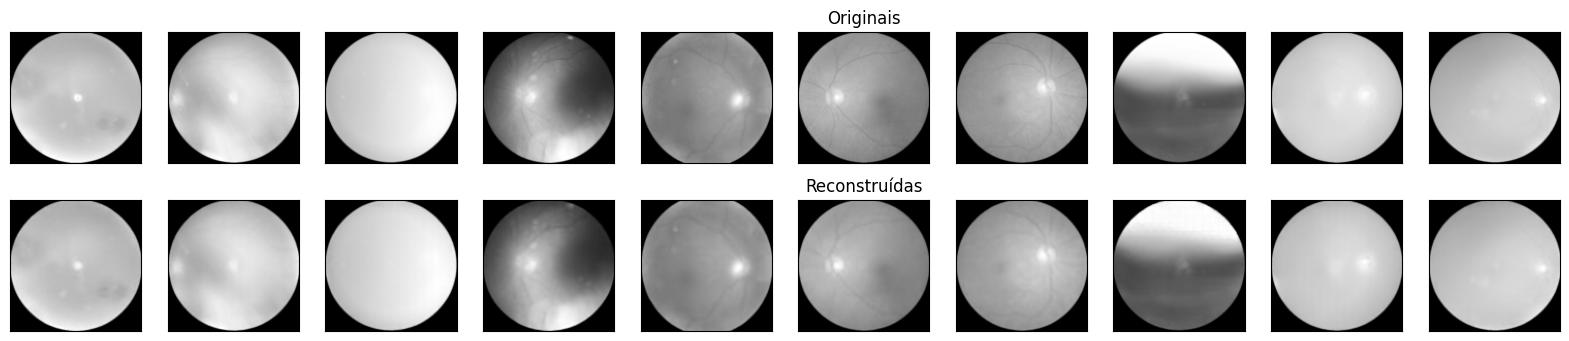


--- Congelando e salvando o encoder ---
Encoder Residual congelado e salvo com sucesso em 'frozen_residual_encoder.pth'!


In [20]:
class ResidualBlock(nn.Module):
    """Bloco Residual para construir o Encoder e Decoder."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Atalho (shortcut) para somar a entrada à saída
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResidualAutoencoder(nn.Module):
    def __init__(self):
        super(ResidualAutoencoder, self).__init__()

        # --- ENCODER ---
        self.initial_conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.res_block1 = ResidualBlock(16, 32, stride=2)  # -> [N, 32, 64, 64]
        self.res_block2 = ResidualBlock(32, 64, stride=2)  # -> [N, 64, 32, 32]
        self.res_block3 = ResidualBlock(64, 128, stride=2) # -> [N, 128, 16, 16]

        # --- DECODER ---
        self.res_block4 = ResidualBlock(128, 128)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # -> [N, 64, 32, 32]

        self.res_block5 = ResidualBlock(64, 64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # -> [N, 32, 64, 64]

        self.res_block6 = ResidualBlock(32, 32)
        self.upsample3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # -> [N, 16, 128, 128]

        self.final_conv = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def encode(self, x):
        out = self.relu(self.bn1(self.initial_conv(x)))
        out = self.res_block1(out)
        out = self.res_block2(out)
        out = self.res_block3(out)
        return out

    def decode(self, z):
        out = self.res_block4(z)
        out = self.upsample1(out)
        out = self.res_block5(out)
        out = self.upsample2(out)
        out = self.res_block6(out)
        out = self.upsample3(out)
        out = self.final_conv(out)
        out = self.tanh(out)
        return out

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

# ==============================================================================
# --- 4. TREINAMENTO DO MODELO COM MÉTRICAS (SEÇÃO MODIFICADA) ---
# ==============================================================================

# Apenas execute se o dataset não estiver vazio
if len(full_dataset) > 0:
    model_res = ResidualAutoencoder().to(DEVICE)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model_res.parameters(), lr=LEARNING_RATE)

    # Instanciar os objetos das métricas
    psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)
    nrmse_metric = NormalizedRootMeanSquaredError().to(DEVICE)

    print("\n--- Iniciando o treinamento do Autoencoder Residual ---")
    for epoch in range(EPOCHS):
        model_res.train()
        total_loss = 0

        # CORREÇÃO: Removido o 'tqdm()' para limpar a saída do console.
        for images, _ in train_loader:
            images = images.to(DEVICE)

            outputs = model_res(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            psnr_metric.update(outputs, images)
            ssim_metric.update(outputs, images)
            nrmse_metric.update(outputs, images)

        epoch_psnr = psnr_metric.compute()
        epoch_ssim = ssim_metric.compute()
        epoch_nrmse = nrmse_metric.compute()
        psnr_metric.reset(); ssim_metric.reset(); nrmse_metric.reset()

        avg_loss = total_loss / len(train_loader)

        # O print já estava no formato correto.
        print(f"Residual AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, "
              f"PSNR: {epoch_psnr:.2f} dB, SSIM: {epoch_ssim:.4f}, NRMSE: {epoch_nrmse:.4f}")

# ==============================================================================
# --- 5. VISUALIZAÇÃO E MÉTRICAS FINAIS NO TESTE (sem alterações) ---
# ==============================================================================
if len(full_dataset) > 0:
    print("\n--- Visualizando e Avaliando resultados no conjunto de teste ---")
    model_res.eval()
    with torch.no_grad():
        data_iter = iter(test_loader)
        test_images, _ = next(data_iter)
        test_images = test_images.to(DEVICE)

        reconstructed_images = model_res(test_images)

        psnr_val = psnr_metric(reconstructed_images, test_images)
        ssim_val = ssim_metric(reconstructed_images, test_images)
        nrmse_val = nrmse_metric(reconstructed_images, test_images)

        print(f"Métricas no Lote de Teste -> PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | NRMSE: {nrmse_val:.4f}")

        plot_images(test_images, reconstructed_images)

# ==============================================================================
# --- 6. CONGELAR E SALVAR O ENCODER TREINADO (sem alterações) ---
# ==============================================================================
if len(full_dataset) > 0:
    print("\n--- Congelando e salvando o encoder ---")

    trained_encoder = nn.Sequential(
        model_res.initial_conv,
        model_res.bn1,
        model_res.relu,
        model_res.res_block1,
        model_res.res_block2,
        model_res.res_block3
    ).to(DEVICE)
    trained_encoder.eval()

    for param in trained_encoder.parameters():
        param.requires_grad = False

    torch.save(trained_encoder.state_dict(), 'frozen_residual_encoder.pth')

    print("Encoder Residual congelado e salvo com sucesso em 'frozen_residual_encoder.pth'!")